In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats.stats import pearsonr

In [4]:
#Set up sns
sns.set(style='white',context='notebook',palette='deep')
colors=['#66c2ff','#5cd6d6','#c2c2d6','#00cc99','#ffd966','#dab3ff']
sns.set_palette(palette=colors,n_colors=4)

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train_ID = train['Id']
test_ID = test['Id']

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)

train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Remove Outliers**

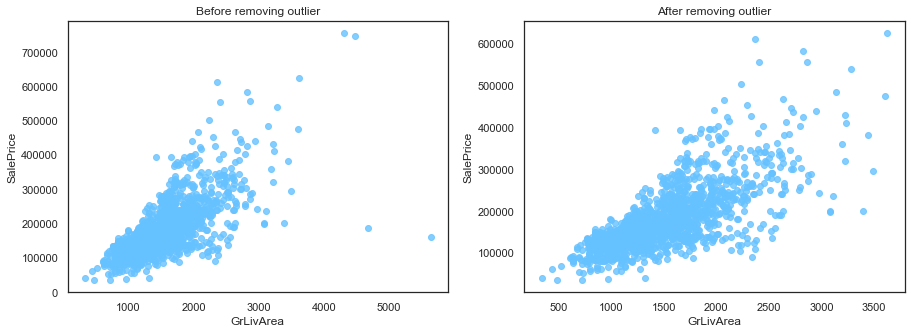

In [8]:
plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title('Before removing outlier')

plt.subplot(1,2,2)
train = train.drop(train[(train['GrLivArea'] > 4000)].index)
g = sns.regplot(x=train['GrLivArea'], y=train['SalePrice'], fit_reg=False).set_title('After removing outlier')

**Dealing with missing value**

In [9]:
#First combine two dataset into one for easier imputation
rtrain = train.shape[0]
rtest = test.shape[0]

#Store SalePrice and remove
y_train = train['SalePrice']

combined = pd.concat((train, test)).reset_index(drop=True)
combined.drop(['SalePrice'],axis=1, inplace=True)
print('Shape of combined dataset: ', combined.shape)

Shape of combined dataset:  (2915, 79)


d:\python demo\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


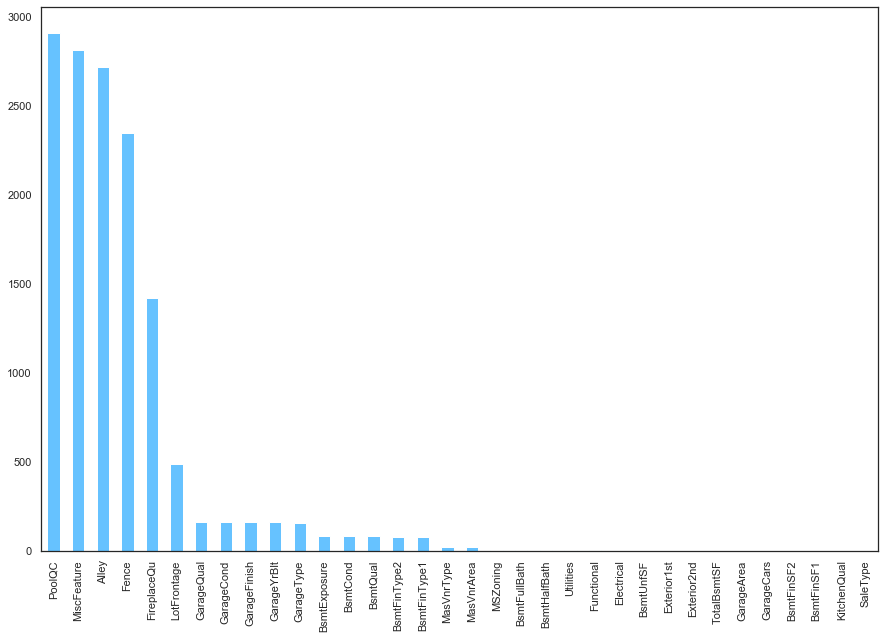

In [10]:
combined_na = combined.isnull().sum()
combined_na = combined_na.drop(combined_na[combined_na == 0].index).sort_values(ascending=False)
plt.subplots(figsize=(15,10))
combined_na.plot(kind='bar')

In [11]:
def checkMissing():
    combined_na = combined.isnull().sum()
    print('Features with missing value: ', combined_na.drop(combined_na[combined_na==0].index))

In [12]:
for feature in ('PoolQC', 'MiscFeature','Alley','Fence','FireplaceQu','GarageQual','GarageType','GarageFinish','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MSSubClass','MasVnrType'):
    combined[feature] = combined[feature].fillna('None')

In [13]:
combined['LotFrontage'] = combined.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [14]:
for feature in ('GarageYrBlt', 'GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF','MasVnrArea','BsmtFullBath','BsmtHalfBath'):
    combined[feature] = combined[feature].fillna(0)


In [15]:
#For these features with just a few missing value below, fill in with their most frequent value
def imputeMode(feature):
    mode = combined[feature].value_counts().index[0]
    combined[feature] = combined[feature].fillna(mode)

In [16]:
imputeMode('MSZoning')
imputeMode('Electrical')
imputeMode('KitchenQual')
imputeMode('Exterior1st')
imputeMode('Exterior2nd')
imputeMode('SaleType')
imputeMode('Functional')
print('Imputation Mode Done.')

Imputation Mode Done.


In [17]:
checkMissing()

Features with missing value:  Utilities    2
dtype: int64


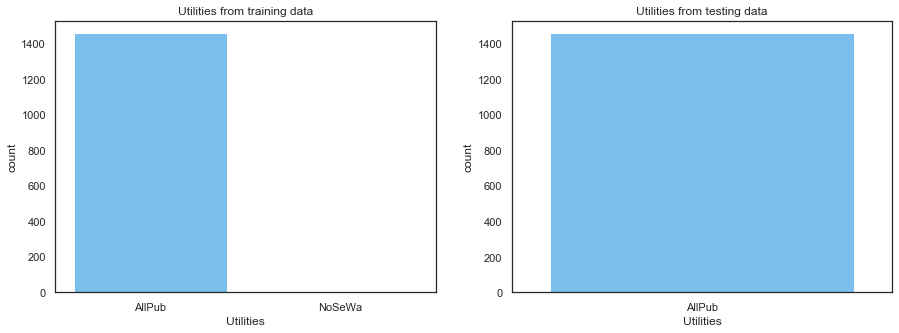

In [18]:
#Take a closer inpect on how Utilities feature behave
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
g = sns.countplot(x='Utilities', data=train).set_title('Utilities from training data')

plt.subplot(1,2,2)
g = sns.countplot(x='Utilities', data=test).set_title('Utilities from testing data')

In [19]:
#Since in the testing data the Utilities feature doesn't vary so we'll drop this data.
combined = combined.drop('Utilities', axis=1)

In [20]:
checkMissing()

Features with missing value:  Series([], dtype: int64)


**EDA**

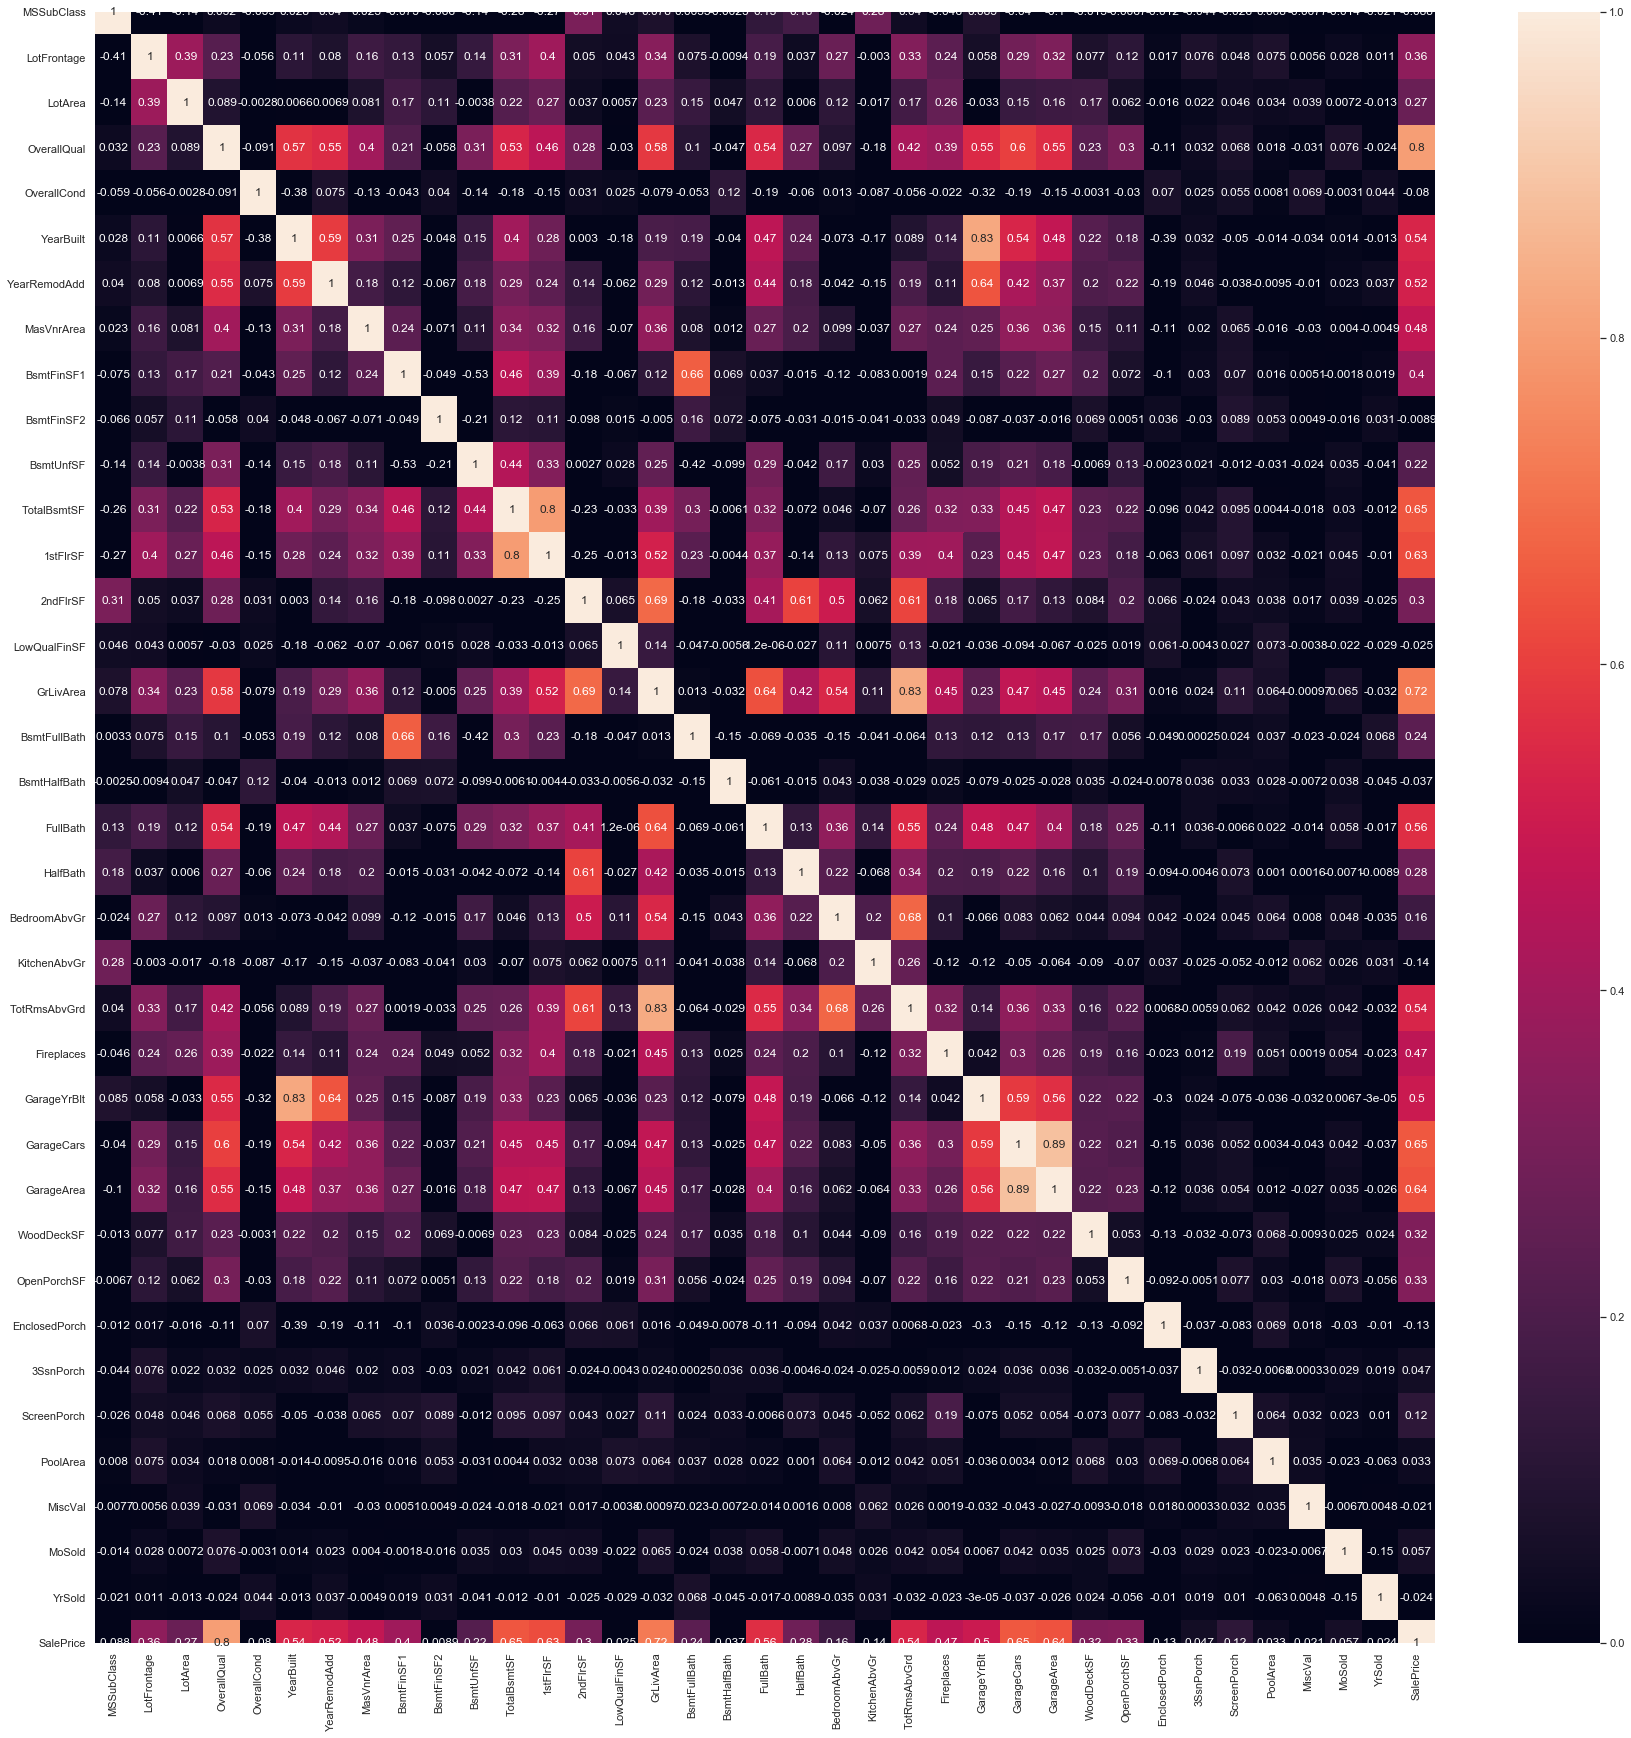

In [21]:
#Produce correlation heatmap
corr = train.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corr,vmax=1, vmin=0,annot=True)

**Feature Engineering**

In [22]:
#Top influencing features would get polynomials
feat_poly = ['OverallQual','GrLivArea','GarageCars',
             'GarageArea','TotalBsmtSF','1stFlrSF',
             'FullBath','TotRmsAbvGrd','Fireplaces',
             'MasVnrArea','BsmtFinSF1','LotFrontage',
             'WoodDeckSF','OpenPorchSF','2ndFlrSF']

In [23]:
for feature in feat_poly:
    combined[feature + '-2'] = combined[feature] ** 2

In [24]:
for feature in feat_poly:
    combined[feature + '-3'] = combined[feature] ** 3

In [25]:
for feature in feat_poly:
    combined[feature + '-4'] = combined[feature] ** 4

In [26]:
def generatePlots(feature, order=None):
    if order==True:
        plot_order=train[feature].value_counts().sort_values(ascending=True).index
    else:plot_order=order
    plt.subplots(figsize=(20,5))
    
    plt.subplot(1,3,1)
    sns.boxplot(x=feature, y='SalePrice', data=train, order=plot_order)
    
    plt.subplot(1,3,2)
    sns.stripplot(x=feature, y='SalePrice',data=train, size=5, jitter=True, order=plot_order)
    
    plt.subplot(1,3,3)
    sns.barplot(x=feature, y='SalePrice', data=train, order=plot_order)

*BsmtQual*

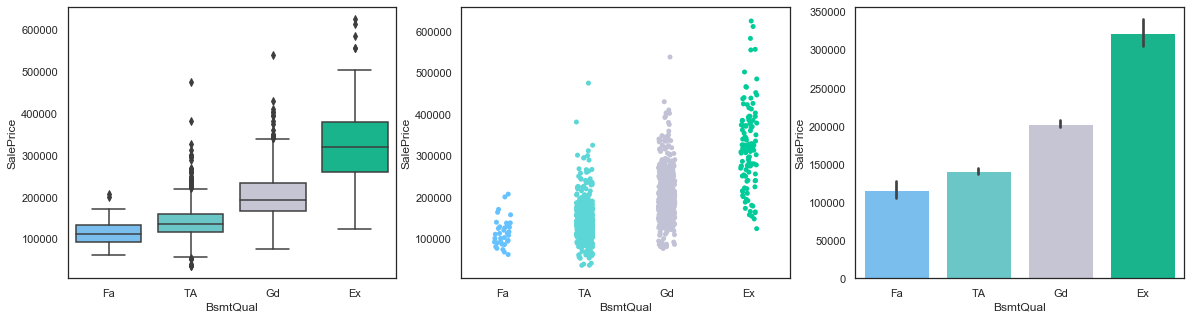

In [27]:
generatePlots('BsmtQual',['Fa','TA','Gd','Ex'])

In [28]:
combined['BsmtQual'] = combined['BsmtQual'].map({'None':0, "Fa":1,"TA":2,"Gd":3,"Ex":4})
combined['BsmtQual'].unique()

array([3, 2, 4, 0, 1], dtype=int64)

*BsmtCond*

In [ ]:
generatePlots('BsmtCond',['Po','Fa','TA','Gd'])

In [ ]:
combined['BsmtCond'] = combined['BsmtCond'].map({'None':0, "Po":1,"Fa":2,"TA":3,"Gd":4, 'Ex':5})
combined['BsmtCond'].unique()

*BsmtExposure*


In [ ]:
generatePlots('BsmtExposure',['No','Mn','Av','Gd'])

In [ ]:
combined['BsmtExposure'] = combined['BsmtExposure'].map({'None':0, "No":1,"Mn":2,"Av":3,"Gd":4})
combined['BsmtExposure'].unique()

*BsmtFinType1*

In [ ]:
generatePlots('BsmtFinType1',['Unf','LwQ','Rec','BLQ','ALQ','GLQ'])

In [ ]:
combined = pd.get_dummies(combined, columns=['BsmtFinType1'],prefix='BsmtFinType1')

*BsmtFinSF1 * *

In [38]:
combined['BsmtFinSF1_Band'] = pd.cut(combined['BsmtFinSF1'],4)

KeyError: 'BsmtFinSF1'

In [33]:
combined['BsmtFinSF1_Band'].unique()

[(-4.01, 1002.5], (1002.5, 2005.0], (2005.0, 3007.5], (3007.5, 4010.0]]
Categories (4, interval[float64]): [(-4.01, 1002.5] < (1002.5, 2005.0] < (2005.0, 3007.5] < (3007.5, 4010.0]]

In [37]:
combined.loc[combined['BsmtFinSF1']<=1002.5, 'BsmtFinSF1'] = 1
combined.loc[(combined['BsmtFinSF1']>1002.5) & (combined['BsmtFinSF1'] <= 2005),'BsmtFinSF1'] = 2
combined.loc[(combined['BsmtFinSF1']>2005) & (combined['BsmtFinSF1'] <= 3007.5),'BsmtFinSF1'] = 3
combined.loc[(combined['BsmtFinSF1']>3007.5) & (combined['BsmtFinSF1'] <= 4010),'BsmtFinSF1'] = 4

combined['BsmtFinSF1'] = combined['BsmtFinSF1'].astype(int)
combined.drop('BsmtFinSF1_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns=['BsmtFinSF1'], prefix='BsmtFinSF1')

KeyError: 'BsmtFinSF1'

In [36]:
combined.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF2,BsmtFinType1,...,BsmtFinSF1-4,LotFrontage-4,WoodDeckSF-4,OpenPorchSF-4,2ndFlrSF-4,TotalBsmtSF_Band,BsmtFinSF1_1,BsmtFinSF1_2,BsmtFinSF1_3,BsmtFinSF1_4
0,856,854,0,None,3,1Fam,TA,No,0.0,GLQ,...,2.484384e+11,17850625.0,0,13845841,531901827856,"(509.5, 1019.0]",1,0,0,0
1,1262,0,0,None,3,1Fam,TA,Gd,0.0,ALQ,...,9.148616e+11,40960000.0,7886150416,0,0,"(1019.0, 1528.5]",1,0,0,0
2,920,866,0,None,3,1Fam,TA,Mn,0.0,GLQ,...,5.578855e+10,21381376.0,0,3111696,562434001936,"(509.5, 1019.0]",1,0,0,0
3,961,756,0,None,3,1Fam,Gd,No,0.0,ALQ,...,2.176782e+09,12960000.0,0,1500625,326653399296,"(509.5, 1019.0]",1,0,0,0
4,1145,1053,0,None,4,1Fam,TA,Av,0.0,GLQ,...,1.840625e+11,49787136.0,1358954496,49787136,1229457398481,"(1019.0, 1528.5]",1,0,0,0


*BsmtFinType2*

In [ ]:
generatePlots('BsmtFinType2',['Unf','LwQ','Rec','BLQ','ALQ','GLQ'])

In [ ]:
combined = pd.get_dummies(combined, columns=['BsmtFinType2'], prefix='BsmtFinType2')
combined.head()

*BsmtFinSF2*

In [ ]:
combined['BsmtFinSF2_Flag'] = combined['BsmtFinSF2'].map(lambda x: 0 if x == 0 else 1)
combined.drop('BsmtFinSF2', axis=1, inplace=True)

*BsmtUnfSF*

In [ ]:
combined['BsmtUnfSF_Band'] = pd.cut(combined['BsmtUnfSF'],3)
combined['BsmtUnfSF_Band'].unique()

In [ ]:
combined.loc[combined['BsmtUnfSF']<=778.667, 'BsmtUnfSF'] = 1
combined.loc[(combined['BsmtUnfSF']>778.667) & (combined['BsmtUnfSF'] <= 1557.333),'BsmtUnfSF'] = 2
combined.loc[(combined['BsmtUnfSF']>1557.333) & (combined['BsmtUnfSF'] <= 2336),'BsmtUnfSF'] = 3

combined['BsmtUnfSF'] = combined['BsmtUnfSF'].astype(int)
combined.drop('BsmtUnfSF_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns=['BsmtUnfSF'], prefix='BsmtUnfSF')

In [ ]:
combined.head()

*TotalBsmtSF*

In [31]:
combined['TotalBsmtSF_Band'] = pd.cut(combined['TotalBsmtSF'], 10)
combined['TotalBsmtSF_Band'].unique()

[(509.5, 1019.0], (1019.0, 1528.5], (1528.5, 2038.0], (-5.095, 509.5], (2038.0, 2547.5], (3057.0, 3566.5], (2547.5, 3057.0], (4585.5, 5095.0]]
Categories (8, interval[float64]): [(-5.095, 509.5] < (509.5, 1019.0] < (1019.0, 1528.5] < (1528.5, 2038.0] < (2038.0, 2547.5] < (2547.5, 3057.0] < (3057.0, 3566.5] < (4585.5, 5095.0]]

In [ ]:
combined.loc[combined['TotalBsmtSF']<=509.5, 'TotalBsmtSF'] = 1
combined.loc[(combined['TotalBsmtSF']>509.5) & (combined['TotalBsmtSF']<=1019), 'TotalBsmtSF'] = 2
combined.loc[(combined['TotalBsmtSF']>1019) & (combined['TotalBsmtSF']<=1528.5), 'TotalBsmtSF'] = 3
combined.loc[(combined['TotalBsmtSF']>1528.5) & (combined['TotalBsmtSF']<=2038), 'TotalBsmtSF'] = 4
combined.loc[(combined['TotalBsmtSF']>2038) & (combined['TotalBsmtSF']<=2547.5), 'TotalBsmtSF'] = 5
combined.loc[(combined['TotalBsmtSF']>2547.5) & (combined['TotalBsmtSF']<=3057), 'TotalBsmtSF'] = 6
combined.loc[(combined['TotalBsmtSF']>3057) & (combined['TotalBsmtSF']<=3566.5), 'TotalBsmtSF'] = 7
combined.loc[combined['TotalBsmtSF']>3566.5, 'TotalBsmtSF'] = 8
combined['TotalBsmtSF'] = combined['TotalBsmtSF'].astype(int)

combined.drop('TotalBsmtSF_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["TotalBsmtSF"], prefix="TotalBsmtSF")
combined.head()

In [ ]:
def binStep1(feature, num_bin):
    combined[feature + '_Band'] = pd.cut(combined[feature], num_bin)
    combined[feature + "_Band"].unique()

In [ ]:
def binStep2(feature, target, minVal=None, maxVal=None):
    if minVal == None and maxVal != None:
        combined.loc[combined[feature]<= maxVal, feature] = target
    elif maxVal == None and minVal != None:
        combined.loc[combined[feature]>minVal, feature] = target
    else:
        combined.loc[(combined[feature]>minVal) & (combined[feature]<=maxVal), feature] = target

In [ ]:
def binStep3(feature):
    combined[feature] = combined[feature].astype(int)

    combined.drop(feature + '_Band', axis=1, inplace=True)

    combined = pd.get_dummies(combined, columns = [feature], prefix=feature)
    combined.head(3)

*1stFlrSF*

In [ ]:
combined['1stFlrSF_Band'] = pd.cut(combined['1stFlrSF'], 6)
combined['1stFlrSF_Band'].unique()

In [ ]:
combined.loc[combined['1stFlrSF']<=1127.5, '1stFlrSF'] = 1
combined.loc[(combined['1stFlrSF']>1127.5) & (combined['1stFlrSF']<=1921), '1stFlrSF'] = 2
combined.loc[(combined['1stFlrSF']>1921) & (combined['1stFlrSF']<=2714.5), '1stFlrSF'] = 3
combined.loc[(combined['1stFlrSF']>2714.5) & (combined['1stFlrSF']<=3508), '1stFlrSF'] = 4
combined.loc[(combined['1stFlrSF']>3508) & (combined['1stFlrSF']<=4301.5), '1stFlrSF'] = 5
combined.loc[combined['1stFlrSF']>4301.5, '1stFlrSF'] = 6
combined['1stFlrSF'] = combined['1stFlrSF'].astype(int)

combined.drop('1stFlrSF_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["1stFlrSF"], prefix="1stFlrSF")
combined.head(3)

*2ndFlrSF*

In [ ]:
grid = plt.GridSpec(2, 3, wspace=0.1, hspace=0.15)
plt.subplots(figsize =(30, 15))

plt.subplot(grid[0, 0])
g = sns.regplot(x=train['2ndFlrSF'], y=train['SalePrice'], fit_reg=False, label = "corr: %2f"%(pearsonr(train['2ndFlrSF'], train['SalePrice'])[0]))
g = g.legend(loc="best")

plt.subplot(grid[0, 1:])
sns.boxplot(x="Neighborhood", y="2ndFlrSF", data=train, palette = colors)

plt.subplot(grid[1, 0]);
sns.barplot(x="BldgType", y="2ndFlrSF", data=train, palette = colors)

plt.subplot(grid[1, 1]);
sns.barplot(x="HouseStyle", y="2ndFlrSF", data=train, palette = colors)

plt.subplot(grid[1, 2]);
sns.barplot(x="LotShape", y="2ndFlrSF", data=train, palette = colors);

In [ ]:
binStep1('2ndFlrSF', 6)

In [ ]:
binStep2('2ndFlrSF', 1, maxVal=310.333)

In [ ]:
binStep2('2ndFlrSF', 2, minVal=310.333,maxVal=620.667)

In [ ]:
binStep2('2ndFlrSF', 3, minVal=620.667,maxVal=931)

In [ ]:
binStep2('2ndFlrSF', 4, minVal=931,maxVal=1241.333)

In [ ]:
binStep2('2ndFlrSF',5, minVal=1241.333,maxVal=1551.667)

In [ ]:
binStep2('2ndFlrSF', 6, minVal=1551.667)

In [ ]:
combined['2ndFlrSF'] = combined['2ndFlrSF'].astype(int)

combined.drop('2ndFlrSF_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["2ndFlrSF"], prefix="2ndFlrSF")
combined.head(3)

*LowQualFinSF*

In [ ]:
combined['LowQualFinSF_Flag'] = combined['LowQualFinSF'].map(lambda x : 0 if x==0 else 1)

In [ ]:
combined.drop('LowQualFinSF', axis=1, inplace=True)

*Sum of all bath rooms*

In [ ]:
combined['TotalBathrooms'] = combined['BsmtHalfBath'] + combined['BsmtFullBath'] + combined['HalfBath'] + combined['FullBath']

In [ ]:
columns = ['BsmtHalfBath','BsmtFullBath','HalfBath','FullBath']

In [ ]:
combined.drop(columns, axis=1, inplace=True)

*BedRoom*

*Kitchen*

*KitchenQual*

In [ ]:
generatePlots('KitchenQual', ['Fa','TA','Gd','Ex'])

In [ ]:
combined['KitchenQual'] = combined['KitchenQual'].map({'Fa':1,"TA":2,"Gd":3,"Ex":4})

In [ ]:
combined['KitchenQual'].unique()

*FireplaceQu*

In [ ]:
generatePlots('FireplaceQu',['Po','Fa','TA','Gd','Ex'])

In [ ]:
combined['FireplaceQu'] = combined['FireplaceQu'].map({'None':0,'Po':1,'Fa':2,"TA":3,"Gd":4,"Ex":5})

In [ ]:
combined['FireplaceQu'].unique()

*GrLivArea*

In [ ]:
binStep1('GrLivArea', 6)

In [ ]:
binStep2('GrLivArea', 1, maxVal=1127.5)

In [ ]:
binStep2('GrLivArea', 2, minVal=1127.5, maxVal=1921)

In [ ]:
binStep2('GrLivArea', 3, minVal=1921, maxVal=2714.5)

In [ ]:
binStep2('GrLivArea', 4, minVal=2714.5, maxVal=3508)

In [ ]:
binStep2('GrLivArea', 5, minVal=3508, maxVal=4301.5)

In [ ]:
binStep2('GrLivArea', 6, minVal=4301.5)

In [ ]:
combined['GrLivArea'] = combined['GrLivArea'].astype(int)

combined.drop('GrLivArea_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["GrLivArea"], prefix="GrLivArea")
combined.head(3)

*MSSubClass*

In [ ]:
generatePlots('MSSubClass')

In [ ]:
combined['MSSubClass'] = combined['MSSubClass'].astype(str)
combined = pd.get_dummies(combined, columns = ["MSSubClass"], prefix="MSSubClass")

*BlogType*

In [ ]:
generatePlots('BldgType')

In [ ]:
combined['BldgType'] = combined['BldgType'].astype(str)
combined = pd.get_dummies(combined, columns=['BldgType'], prefix='BldgType')
combined.head()

*HouseStyle*

In [ ]:
generatePlots('HouseStyle')

In [ ]:
#Cluster those categories with similarity
combined['HouseStyle'] = combined['HouseStyle'].map({"2Story":"2Story", "1Story":"1Story", "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", 
                                                     "SFoyer":"SFoyer", "SLvl":"SLvl", "2.5Unf":"2.5Story", "2.5Fin":"2.5Story"})

combined = pd.get_dummies(combined, columns = ["HouseStyle"], prefix="HouseStyle")
combined.head()

*OverallQual*

In [ ]:
generatePlots('OverallQual')

*OverallCond*

In [ ]:
generatePlots('OverallCond')

*YearRemodAdd*

In [ ]:
generatePlots('YearRemodAdd')

In [ ]:
train['Remod_Diff'] = train['YearRemodAdd'] - train['YearBuilt']

In [ ]:
combined['Remod_Diff'] = combined['YearRemodAdd'] - combined['YearBuilt']
combined.drop('YearRemodAdd', axis=1, inplace=True)

*YearBuilt*

In [ ]:
plt.subplots(figsize=(50,30))
sns.barplot(x='YearBuilt',y='SalePrice',data=train, palette=colors)

In [ ]:
binStep1('YearBuilt', 7)

In [ ]:
binStep2('YearBuilt',1,maxVal=1892)

In [ ]:
binStep2('YearBuilt',2,minVal=1892, maxVal=1911)

In [ ]:
binStep2('YearBuilt',3,minVal=1911, maxVal=1931)

In [ ]:
binStep2('YearBuilt',4,minVal=1931, maxVal=1951)

In [ ]:
binStep2('YearBuilt',5,minVal=1951, maxVal=1971)

In [ ]:
binStep2('YearBuilt',6,minVal=1971, maxVal=1990)

In [ ]:
binStep2('YearBuilt',7,minVal=1990)

In [ ]:
combined['YearBuilt'] = combined['YearBuilt'].astype(int)

combined.drop('YearBuilt_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["YearBuilt"], prefix="YearBuilt")
combined.head(3)

*Foundation*

In [ ]:
generatePlots('Foundation')

In [ ]:
combined = pd.get_dummies(combined,columns=['Foundation'], prefix='Foundation')
combined.head()

*Functional*

In [ ]:
generatePlots('Functional')

In [ ]:
combined['Functional'] = combined['Functional'].map({'Sev':1, 'Maj2':2, 'Maj1': 3, 'Mod':4, 'Min2':5,'Min1':6,'Typ':7})

In [ ]:
combined['Functional'].unique()

*RoofStyle*

In [ ]:
generatePlots('RoofStyle')

In [ ]:
combined = pd.get_dummies(combined, columns = ["RoofStyle"], prefix="RoofStyle")
combined.head(3)

*RoofMatl*

In [ ]:
generatePlots('RoofMatl')

In [ ]:
combined = pd.get_dummies(combined, columns = ["RoofMatl"], prefix="RoofMatl")
combined.head(3)

*Exterior1st & Exterior2nd*

In [ ]:
generatePlots('Exterior1st')

In [ ]:
generatePlots('Exterior2nd')

In [ ]:
def Exter2(col):
    if col['Exterior2nd'] == col['Exterior1st']:
        return 1
    else:
        return 0

In [ ]:
combined['ExteriorMatch_Flag'] = combined.apply(Exter2, axis=1)
combined.drop('Exterior2nd', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["Exterior1st"], prefix="Exterior1st")
combined.head(3)

*MasVnrType*

In [ ]:
generatePlots('MasVnrType')

In [ ]:
combined = pd.get_dummies(combined, columns=['MasVnrType'], prefix='MasVnrType')
combined.head()

*MasVnrType*

In [ ]:
#Since it's correlated highly with MasVnrType and doesn't vary much against SalesPrice, drop this
combined.drop('MasVnrArea', axis=1, inplace=True)

*ExterQual*

In [ ]:
generatePlots('ExterQual')

In [ ]:
combined['ExterQual'] = combined['ExterQual'].map({"Fa":1,"TA":2,"Gd":3,"Ex":4})

In [ ]:
combined['ExterQual'].unique()

*ExterCond*

In [ ]:
generatePlots('ExterCond')

In [ ]:
#We observe an obvious order here but this order has no correlation with SalePrice we don't have to map
combined = pd.get_dummies(combined, columns = ["ExterCond"], prefix="ExterCond")
combined.head(3)

*GarageType*

In [ ]:
generatePlots('GarageType')

In [ ]:
combined = pd.get_dummies(combined, columns = ["GarageType"], prefix="GarageType")
combined.head(3)

*GarageYrBlt*

In [ ]:
plt.subplots(figsize=(50,10))
sns.boxplot(x='GarageYrBlt',y='SalePrice',data=train,palette=colors)

In [ ]:
binStep1('GarageYrBlt', 3)

In [ ]:
binStep2('GarageYrBlt',1,maxVal=1964)

In [ ]:
binStep2('GarageYrBlt',2,minVal=1964, maxVal=1996)

In [ ]:
binStep2('GarageYrBlt',3,minVal=1996)

In [ ]:
combined['GarageYrBlt'] = combined['GarageYrBlt'].astype(int)

combined.drop('GarageYrBlt_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["GarageYrBlt"], prefix="GarageYrBlt")
combined.head(3)

*GarageFinish*

In [ ]:
generatePlots('GarageFinish')

In [ ]:
combined = pd.get_dummies(combined, columns=['GarageFinish'], prefix='GarageFinish')
combined.head()

*GarageCars*

In [ ]:
generatePlots('GarageCars')

*GarageArea*

In [ ]:
binStep1('GarageArea', 3)

In [ ]:
binStep2('GarageArea',1, maxVal=496)

In [ ]:
binStep2('GarageArea',2, minVal=496, maxVal=992)

In [ ]:
binStep2('GarageArea',3, minVal=992)

In [ ]:
combined['GarageArea'] = combined['GarageArea'].astype(int)

combined.drop('GarageArea_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["GarageArea"], prefix="GarageArea")
combined.head(3)

*GarageQual*

In [ ]:
generatePlots('GarageQual',['Po','Fa','TA','Gd','Ex'])

In [ ]:
#Cluster is performed here
combined['GarageQual'] = combined['GarageQual'].map({'None':'None', 'Po':'Low','Fa':'Low','TA':'TA','Gd':'High','Ex':'High'})
combined['GarageQual'].unique()

In [ ]:
combined = pd.get_dummies(combined, columns=['GarageQual'], prefix='GarageQual')
combined.head()

*GarageCond*

In [ ]:
generatePlots('GarageCond',['Po','Fa','TA','Gd','Ex'])

In [ ]:
#Similar distribution with GarageQual
combined['GarageCond'] = combined['GarageCond'].map({'None':'None', 'Po':'Low','Fa':'Low','TA':'TA','Gd':'High','Ex':'High'})
combined['GarageCond'].unique()

In [ ]:
combined = pd.get_dummies(combined, columns=['GarageCond'], prefix='GarageCond')
combined.head()

*WoodDeckSF*

In [ ]:
def WoodDeckFlag(col):
    if col['WoodDeckSF'] == 0:
        return 1
    else:
        return 0

combined['NoWoodDeck_Flag'] = combined.apply(WoodDeckFlag, axis=1)

In [ ]:
binStep1('WoodDeckSF', 4)

In [ ]:
binStep2('WoodDeckSF',1,maxVal=356)

In [ ]:
binStep2('WoodDeckSF',2,minVal=356,maxVal=712)

In [ ]:
binStep2('WoodDeckSF',3, minVal=712, maxVal=1068)

In [ ]:
binStep2('WoodDeckSF',4,maxVal=1068)

In [ ]:
combined['WoodDeckSF'] = combined['WoodDeckSF'].astype(int)

combined.drop('WoodDeckSF_Band', axis=1, inplace=True)
combined = pd.get_dummies(combined, columns = ["WoodDeckSF"], prefix="WoodDeckSF")
combined.head(3)

*OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch*

In [ ]:
combined['TotalPorchSF'] = combined['OpenPorchSF'] + combined['OpenPorchSF'] + combined['EnclosedPorch'] + combined['3SsnPorch'] + combined['ScreenPorch'] 
train['TotalPorchSF'] = train['OpenPorchSF'] + train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']

In [ ]:
def porchFlag(col):
    if col['TotalPorchSF'] == 0:
        return 1
    else:
        return 0


In [ ]:
combined['NoPorch_Flag']= combined.apply(porchFlag, axis=1)
binStep1('TotalPorchSF', 4)

In [ ]:
binStep2('TotalPorchSF', 1, maxVal=431)

In [ ]:
binStep2('TotalPorchSF', 2, minVal=431, maxVal=862)

In [ ]:
binStep2('TotalPorchSF', 3, minVal=862, maxVal=1293)

In [ ]:
binStep2('TotalPorchSF', 4, minVal=1293)

In [ ]:
combined['TotalPorchSF'] = combined['TotalPorchSF'].astype(int)

combined.drop('TotalPorchSF_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["TotalPorchSF"], prefix="TotalPorchSF")
combined.head()

*PoolArea*

In [ ]:
def PoolFlag(col):
    if col['PoolArea'] == 0:
        return 0
    else:
        return 1
    
combined['HasPool_Flag'] = combined.apply(PoolFlag, axis=1)
combined.drop('PoolArea', axis=1, inplace=True)

*PoolQC*

In [ ]:
combined.drop('PoolQC',axis=1, inplace=True)

*Fence*

In [ ]:
generatePlots('Fence',['MnWw','GdWo','MnPrv','GdPrv'])

In [ ]:
combined = pd.get_dummies(combined, columns=['Fence'],prefix='Fence')
combined.head()

*MSZoning*

In [ ]:
generatePlots('MSZoning')

In [ ]:
combined = pd.get_dummies(combined, columns=['MSZoning'],prefix='MSZoning')
combined.head()

*Neighborhood*

In [ ]:
generatePlots('Neighborhood')

In [ ]:
#For categorical feature without order, create dummy feature
combined = pd.get_dummies(combined, columns=['Neighborhood'],prefix='Neighborhood')
combined.head()

*Condition1&Condition2*

In [ ]:
generatePlots('Condition1')

In [ ]:
generatePlots('Condition2')

In [ ]:
combined['Condition1'] = combined['Condition1'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
combined['Condition2'] = combined['Condition2'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})

In [ ]:
def ConditionMatch(col):
    if col['Condition1'] == col['Condition2']:
        return 0
    else:
        return 1
    
combined['Diff2ndCondition_Flag'] = combined.apply(ConditionMatch, axis=1)
combined.drop('Condition2', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["Condition1"], prefix="Condition1")
combined.head(3)

*LotFrontage*

*LotArea*

In [ ]:
binStep1('LotArea', 8)

In [ ]:
nums = [5684.75, 7474, 8520, 9450, 10355.25, 11554.25, 13613]
binStep2('LotArea',1,maxVal=nums[0])
binStep2('LotArea',2,minVal=nums[0], maxVal=nums[1])
binStep2('LotArea',3,minVal=nums[1], maxVal=nums[2])
binStep2('LotArea',4,minVal=nums[2], maxVal=nums[3])
binStep2('LotArea',5,minVal=nums[3], maxVal=nums[4])
binStep2('LotArea',6,minVal=nums[4], maxVal=nums[5])
binStep2('LotArea',7,minVal=nums[5], maxVal=nums[6])
binStep2('LotArea',8,minVal=nums[6])

In [ ]:
combined['LotArea'] = combined['LotArea'].astype(int)

combined.drop('LotArea_Band', axis=1, inplace=True)

combined = pd.get_dummies(combined, columns = ["LotArea"], prefix="LotArea")
combined.head(3)

*LotShape*

In [ ]:
generatePlots('LotShape')

In [ ]:
combined = pd.get_dummies(combined, columns = ["LotShape"], prefix="LotShape")
combined.head(3)

*LandContour*

In [ ]:
generatePlots('LandContour')

In [ ]:
combined = pd.get_dummies(combined, columns = ["LandContour"], prefix="LandContour")
combined.head(3)

*LotConfig***

In [ ]:
generatePlots('LotConfig')

In [ ]:
combined['LotConfig'] = combined['LotConfig'].map({"Inside":"Inside", "FR2":"FR", "Corner":"Corner", "CulDSac":"CulDSac", "FR3":"FR"})

combined = pd.get_dummies(combined, columns = ["LotConfig"], prefix="LotConfig")
combined.head(3)

*LandSlope*

In [ ]:
generatePlots('LandSlope')

In [ ]:
combined['LandSlope'] = combined['LandSlope'].map({"Gtl":1, "Mod":2, "Sev":2})

In [ ]:
def Slope(col):
    if col['LandSlope'] == 1:
        return 1
    else:
        return 0
    
combined['GentleSlope_Flag'] = combined.apply(Slope, axis=1)
combined.drop('LandSlope', axis=1, inplace=True)

*Street*

In [ ]:
generatePlots('Street')

In [ ]:
combined.drop('Street',axis=1, inplace=True)

*Alley*

In [ ]:
generatePlots('Alley')

In [ ]:
combined = pd.get_dummies(combined, columns = ["Alley"], prefix="Alley")
combined.head(3)

*PavedDrive*

In [ ]:
generatePlots('PavedDrive')

In [ ]:
combined = pd.get_dummies(combined, columns = ["PavedDrive"], prefix="PavedDrive")
combined.head(3)

*Heating*

In [ ]:
generatePlots('Heating')

In [ ]:
combined['GasA_Flag'] = combined['Heating'].map({"GasA":1, "GasW":0, "Grav":0, "Wall":0, "OthW":0, "Floor":0})
combined.drop('Heating', axis=1, inplace=True)
combined.head(3)

*HeatingQC*

In [ ]:
generatePlots('HeatingQC')

In [ ]:
combined['HeatingQC'] = combined['HeatingQC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
combined['HeatingQC'].unique()

*CentralAir*

In [ ]:
generatePlots('CentralAir')

In [ ]:
combined['CentralAir'] = combined['CentralAir'].map({"Y":1, "N":0})
combined['CentralAir'].unique()

*Electrical*

In [ ]:
generatePlots('Electrical')

In [ ]:
combined['Electrical'] = combined['Electrical'].map({"SBrkr":"SBrkr", "FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse", "Mix":"Mix"})

combined = pd.get_dummies(combined, columns = ["Electrical"], prefix="Electrical")
combined.head(3)

*MiscFeature*

In [ ]:
generatePlots('MiscFeature')

In [ ]:
columns=['MiscFeature', 'MiscVal']
combined.drop(columns, axis=1, inplace=True)

*MoSold*

In [ ]:
generatePlots('MoSold')

In [ ]:
combined = pd.get_dummies(combined, columns = ["MoSold"], prefix="MoSold")
combined.head(3)

*YrSold*

In [ ]:
generatePlots('YrSold')

In [ ]:
combined = pd.get_dummies(combined, columns = ["YrSold"], prefix="YrSold")
combined.head(3)

*SaleType*

In [ ]:
generatePlots('SaleType')

In [ ]:
combined['SaleType'] = combined['SaleType'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", "ConLI":"Oth", 
                                                 "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})

combined = pd.get_dummies(combined, columns = ["SaleType"], prefix="SaleType")
combined.head(3)

*SaleCondition*

In [ ]:
generatePlots('SaleCondition')

In [ ]:
combined = pd.get_dummies(combined, columns = ["SaleCondition"], prefix="SaleCondition")

In [ ]:
combined.head()

In [ ]:
plt.subplots(figsize=(15,10))
g = sns.distplot(train['SalePrice'], fit=norm, label='Skewness : %.2f'%train['SalePrice'].skew())
g = g.legend(loc='best')

In [ ]:
train['SalePrice'] = np.log1p(train['SalePrice'])
y_train = train['SalePrice']

In [ ]:
plt.subplots(figsize=(15,10))
g = sns.distplot(train['SalePrice'], fit=norm, label='Skewness : %.2f'%train['SalePrice'].skew())
g = g.legend(loc='best')

In [ ]:
#Treating skewed features in numeric
numeric_feats = combined.dtypes[combined.dtypes != 'object'].index
skewed_feats = combined[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

plt.subplots(figsize=(65,30))
skewed_feats.plot(kind='bar')

In [ ]:
#Apply Box-Cox
skewness = skewed_feats[abs(skewed_feats) > 0.5]
skewed_features = skewness.index
lam=0.15
for feat in skewed_features:
    combined[feat] = boxcox1p(combined[feat], lam)
print(skewness.shape[0])

*Modeling*

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [236]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb

In [ ]:
train = combined[:rtrain]
test = combined[rtrain:]

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
import xgboost as xgb
xbgr = xgb.XGBRegressor()
xbgr.fit(train, y_train)

In [ ]:
indices = np.argsort(xbgr.feature_importances_)[::-1]
indices = indices[:75]

In [ ]:
plt.subplots(figsize=(20,15))
g = sns.barplot(y=train.columns[indices], x = xbgr.feature_importances_[indices], orient='h', palette = colors)
g.set_xlabel("Importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title('XGB feature importance')

In [ ]:
xgb_train = train.copy()
xgb_test = test.copy()

In [ ]:
xgbr = xgb.XGBRegressor()
xgbr.fit(xgb_train, y_train)

In [ ]:
xgb_feat_red = SelectFromModel(xgbr, prefit=True)

In [ ]:
xgb_train = xgb_feat_red.transform(xgb_train)
xgb_test = xgb_feat_red.transform(xgb_test)

In [ ]:
print('Feature reduction:')
print('X_train: ', xgb_train.shape, 'X_test', xgb_test.shape)

In [233]:
X_train, X_test, y_train, y_test = train_test_split(xgb_train, y_train, test_size=0.3, random_state=42)

In [234]:
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape, 'y_train: ', y_train.shape, 'y_test: ', y_test.shape)

X_train:  (1019, 45) X_test:  (437, 45) y_train:  (1019,) y_test:  (437,)


In [237]:
models = [KernelRidge(),ElasticNet(), Lasso(),GradientBoostingRegressor(),BayesianRidge(),LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

In [243]:
shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [244]:
columns =  ['Name','Parameters','Train Accuracy Mean','Test Accuracy']
before_model_compare = pd.DataFrame(columns=columns)

In [251]:
row_index = 0
for alg in models:
    model_name = alg.__class__.__name__
    before_model_compare.loc[row_index, 'Name'] = model_name
    before_model_compare.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, y_train)
    
    training_re = np.sqrt((-cross_val_score(alg, X_train, y_train, cv=shuff, scoring='neg_mean_squared_error')).mean())
    test_re = np.sqrt(((y_test-alg.predict(X_test)) ** 2).mean())
    
    before_model_compare.loc[row_index, 'Train Accuracy Mean'] = (training_re) * 100
    before_model_compare.loc[row_index,'Test Accuracy Mean'] = (test_re) * 100
    
    row_index += 1
    print(row_index, alg.__class__.__name__, 'trained.')

decimals = 3
before_model_compare['Train Accuracy Mean'] = before_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare['Test Accuracy'] = before_model_compare['Test Accuracy Mean'].apply(lambda x: round(x, decimals))
before_model_compare

1 KernelRidge trained.
2 ElasticNet trained.
3 Lasso trained.
4 GradientBoostingRegressor trained.
5 BayesianRidge trained.
6 LassoLarsIC trained.
7 RandomForestRegressor trained.
[15:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor trained.


,Name,Parameters,Train Accuracy Mean,Test Accuracy,Test Accuracy Mean
0,KernelRidge,"{'alpha': 1, 'coef0': 1, 'degree': 3, 'gamma':...",31.517,32.314,32.313727
1,ElasticNet,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",22.118,22.629,22.628826
2,Lasso,"{'alpha': 1.0, 'copy_X': True, 'fit_intercept'...",27.129,27.394,27.394226
3,GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",12.732,12.414,12.414110
4,BayesianRidge,"{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...",11.375,11.818,11.817548
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 2....",11.569,11.757,11.757406
6,RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",14.403,14.899,14.899103
7,XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",12.514,12.332,12.331515


In [254]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]

KR_param_grid = {'alpha': [0.1], 'coef0': [100], 'degree': [1], 'gamma': [None], 'kernel': ['polynomial']}
EN_param_grid = {'alpha': [0.001], 'copy_X': [True], 'l1_ratio': [0.6], 'fit_intercept': [True], 'normalize': [False], 
                         'precompute': [False], 'max_iter': [300], 'tol': [0.001], 'selection': ['random'], 'random_state': [None]}
LASS_param_grid = {'alpha': [0.0005], 'copy_X': [True], 'fit_intercept': [True], 'normalize': [False], 'precompute': [False], 
                    'max_iter': [300], 'tol': [0.01], 'selection': ['random'], 'random_state': [None]}
GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [300], 'max_depth': [3], 
                                        'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
BR_param_grid = {'n_iter': [200], 'tol': [0.00001], 'alpha_1': [0.00000001], 'alpha_2': [0.000005], 'lambda_1': [0.000005], 
                 'lambda_2': [0.00000001], 'copy_X': [True]}
LL_param_grid = {'criterion': ['aic'], 'normalize': [True], 'max_iter': [100], 'copy_X': [True], 'precompute': ['auto'], 'eps': [0.000001]}
RFR_param_grid = {'n_estimators': [50], 'max_features': ['auto'], 'max_depth': [None], 'min_samples_split': [5], 'min_samples_leaf': [2]}
XGB_param_grid = {'max_depth': [3], 'learning_rate': [0.1], 'n_estimators': [300], 'booster': ['gbtree'], 'gamma': [0], 'reg_alpha': [0.1],
                  'reg_lambda': [0.7], 'max_delta_step': [0], 'min_child_weight': [1], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.2],
                  'scale_pos_weight': [1]}
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]

after_model_compare = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)

    #set name and parameters
    model_name = alg.__class__.__name__
    after_model_compare.loc[row_index, 'Name'] = model_name
    
    gs_alg.fit(X_train, y_train)
    gs_best = gs_alg.best_estimator_
    after_model_compare.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    after_training_results = np.sqrt(-gs_alg.best_score_)
    after_test_results = np.sqrt(((y_test-gs_alg.predict(X_test))**2).mean())
    
    after_model_compare.loc[row_index, 'Train Accuracy Mean'] = (after_training_results)*100
    after_model_compare.loc[row_index, 'Test Accuracy'] = (after_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
after_model_compare['Train Accuracy Mean'] = after_model_compare['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
after_model_compare['Test Accuracy'] = after_model_compare['Test Accuracy'].apply(lambda x: round(x, decimals))
after_model_compare

1 KernelRidge trained...
2 ElasticNet trained...
3 Lasso trained...
4 GradientBoostingRegressor trained...
5 BayesianRidge trained...
6 LassoLarsIC trained...
7 RandomForestRegressor trained...


/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KernelRidge,"{'alpha': 0.1, 'coef0': 100, 'degree': 1, 'gam...",11.376,11.923
1,ElasticNet,"{'alpha': 0.001, 'copy_X': True, 'fit_intercep...",11.487,12.002
2,Lasso,"{'alpha': 0.0005, 'copy_X': True, 'fit_interce...",11.465,11.907
3,GradientBoostingRegressor,"{'learning_rate': 0.1, 'loss': 'huber', 'max_d...",12.107,12.291
4,BayesianRidge,"{'alpha_1': 1e-08, 'alpha_2': 5e-06, 'copy_X':...",11.375,11.818
5,LassoLarsIC,"{'copy_X': True, 'criterion': 'aic', 'eps': 1e...",11.569,11.757
6,RandomForestRegressor,"{'max_depth': None, 'max_features': 'auto', 'm...",13.644,14.140
7,XGBRegressor,"{'booster': 'gbtree', 'colsample_bylevel': 0.2...",12.208,11.950


*Stacking*

In [268]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, y_train)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc = row_index, column = names[0], value = gs_best.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = names[0], value = gs_best.predict(xgb_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    names.pop(0)
    
    row_index+=1
    
print('Done')

1 KernelRidge predictions added to stacking validation dataset...
1 KernelRidge predictions added to stacking test dataset...
--------------------------------------------------
2 ElasticNet predictions added to stacking validation dataset...
2 ElasticNet predictions added to stacking test dataset...
--------------------------------------------------
3 Lasso predictions added to stacking validation dataset...
3 Lasso predictions added to stacking test dataset...
--------------------------------------------------
4 GradientBoostingRegressor predictions added to stacking validation dataset...
4 GradientBoostingRegressor predictions added to stacking test dataset...
--------------------------------------------------
5 BayesianRidge predictions added to stacking validation dataset...
5 BayesianRidge predictions added to stacking test dataset...
--------------------------------------------------
6 LassoLarsIC predictions added to stacking validation dataset...
6 LassoLarsIC predictions added

/opt/conda/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:58:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor predictions added to stacking validation dataset...
8 XGBRegressor predictions added to stacking test dataset...
--------------------------------------------------
Done


In [269]:
stacked_validation_train.head()

,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,12.097838,12.099544,12.099655,12.109385,12.096525,12.100640,12.133759,12.120995
1,11.967256,11.966463,11.966292,12.041172,11.972548,11.977517,12.074685,12.041072
2,11.798861,11.804574,11.809964,11.854919,11.806828,11.809399,11.861684,11.829997
3,11.827207,11.818461,11.823268,11.827363,11.832695,11.851603,11.700799,11.768791
4,11.275378,11.256968,11.261051,11.140688,11.276457,11.290995,11.350956,11.275813


In [270]:
drop = ['Bayesian Ridge']
stacked_validation_train.drop(drop, axis=1, inplace=True)
stacked_test_train.drop(drop, axis=1, inplace=True)

# Now fit the meta model and generate predictions
meta_model = make_pipeline(RobustScaler(), BayesianRidge(n_iter=200,alpha_1=0.00000001, alpha_2 = 0.000005, copy_X = True,tol = 0.00001,lambda_1=0.000005, lambda_2=0.00000001))
meta_model.fit(stacked_validation_train, y_test)

meta_model_pred = np.expm1(meta_model.predict(stacked_test_train))
print("Meta-model trained and applied!...")

TypeError: __init__() got an unexpected keyword argument 'alpha1'

In [261]:
models = [KernelRidge(), ElasticNet(), Lasso(), GradientBoostingRegressor(), BayesianRidge(), LassoLarsIC(), RandomForestRegressor(), xgb.XGBRegressor()]
names = ['KernelRidge', 'ElasticNet', 'Lasso', 'Gradient Boosting', 'Bayesian Ridge', 'Lasso Lars IC', 'Random Forest', 'XGBoost']
params_grid = [KR_param_grid, EN_param_grid, LASS_param_grid, GB_param_grid, BR_param_grid, LL_param_grid, RFR_param_grid, XGB_param_grid]
final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(stacked_validation_train, y_test)
    gs_best = gs_alg.best_estimator_
    final_predictions.insert(loc = row_index, column = names[0], value = np.expm1(gs_best.predict(stacked_test_train)))
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    names.pop(0)
    
    row_index+=1

print("-"*50)
print("Done")
    
final_predictions.head()

1 KernelRidge final results predicted added to table...
2 ElasticNet final results predicted added to table...
3 Lasso final results predicted added to table...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07242200317840997, tolerance: 0.06483051719467418
  positive)


4 GradientBoostingRegressor final results predicted added to table...
5 BayesianRidge final results predicted added to table...
6 LassoLarsIC final results predicted added to table...
7 RandomForestRegressor final results predicted added to table...
[15:51:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8 XGBRegressor final results predicted added to table...
--------------------------------------------------
Done


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


,KernelRidge,ElasticNet,Lasso,Gradient Boosting,Bayesian Ridge,Lasso Lars IC,Random Forest,XGBoost
0,116165.042816,116222.274881,114280.960422,113297.207378,115649.645999,115954.663882,95313.919424,84182.28125
1,165566.174249,165536.500003,167359.276660,170387.469359,162850.108492,165034.917900,167119.383260,165122.37500
2,182835.846525,183178.642507,183863.479234,179446.976769,182338.325236,182893.715263,182581.144231,178307.15625
3,195119.625732,195176.634815,196040.573523,196533.333994,191211.857709,194470.498878,191611.914783,188379.34375
4,187431.539872,186998.377290,187700.950945,180938.577798,186516.324482,187640.347532,181704.004026,178857.25000


In [262]:
ensemble = meta_model_pred*(1/10) + final_predictions['XGBoost']*(1.5/10) + final_predictions['Gradient Boosting']*(2/10) + final_predictions['Bayesian Ridge']*(1/10) + final_predictions['Lasso']*(1/10) + final_predictions['KernelRidge']*(1/10) + final_predictions['Lasso Lars IC']*(1/10) + final_predictions['Random Forest']*(1.5/10)

submission = pd.DataFrame()
submission['Id'] = test_ID
submission['SalePrice'] = ensemble
submission.to_csv('final_submission.csv',index=False)
print("Submission file, created!")

Submission file, created!
